In [4]:
from metpy.plots import SkewT
from metpy.units import units
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd

In [17]:
ds = gpd.read_file('data/cabauw-23042025.geojson').to_xarray()
ds

<xarray.Dataset> Size: 30kB
Dimensions:   (index: 373)
Coordinates:
  * index     (index) int64 3kB 0 1 2 3 4 5 6 7 ... 366 367 368 369 370 371 372
Data variables:
    time      (index) float64 3kB 1.745e+09 1.745e+09 ... 1.745e+09 nan
    gpheight  (index) float64 3kB 2.0 9.0 112.0 ... 3.397e+04 3.407e+04 nan
    temp      (index) float64 3kB 285.2 285.3 284.6 284.5 ... 229.4 230.3 nan
    dewpoint  (index) float64 3kB 282.6 282.9 282.2 282.2 ... 190.7 190.9 nan
    pressure  (index) float64 3kB 1.015e+03 1.014e+03 1.002e+03 ... 6.3 6.2 nan
    wind_u    (index) float64 3kB -1.03 -0.38 -2.47 -2.65 ... -2.6 -2.22 0.6 nan
    wind_v    (index) float64 3kB -2.82 -1.24 -3.27 -3.39 ... -5.79 -5.67 nan
    flags     (index) float64 3kB 1.454e+05 2.048e+03 nan ... nan 1.435e+04 nan
    geometry  (index) object 3kB POINT Z (5.177 52.1 2) ... LINESTRING Z (5.1...

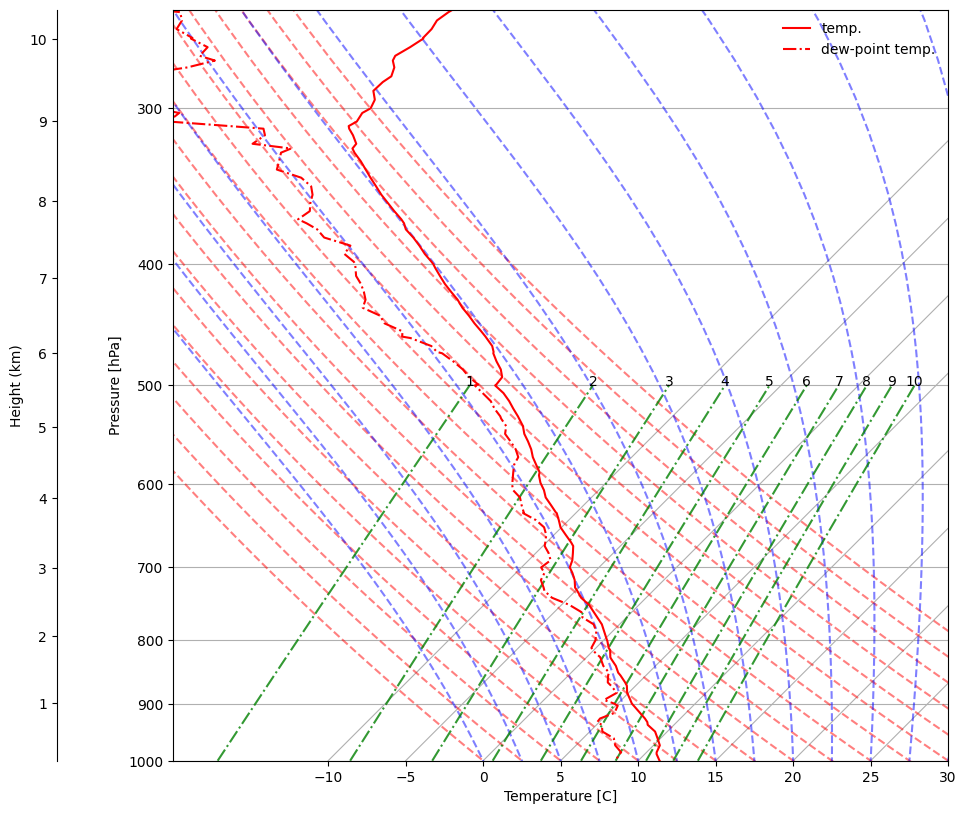

In [25]:
Rd = 287.05
Rv = 461.5 # J/kg/K, gas constant of water
lv_trip = 2500e3 # J/kg, latent heat of vaporisation at the triple point of water
T_trip = 273.15 # K, Temperature for triple point of water at 1000 hPa air pressure
es_trip = 610.94 # Pa, equilibrium vapour pressure at triple point of water


# Tad = np.hstack((np.arange(T_trip, T_trip+45, 2.5), np.arange(T_trip+15, T_trip+25, 2.5)))
Tad = np.arange(T_trip, T_trip+45, 2.5)

fig = plt.figure()
skew = SkewT(fig, rotation=45)
skew.plot_dry_adiabats(Tad*units('K'))
skew.plot_moist_adiabats(Tad*units('K'))
skew.ax.set_xlabel('Temperature [C]')
skew.ax.set_ylabel('Pressure [hPa]')
skew.ax.set_ylim(1000, 250)

skew.ax.set_xticks(np.arange(-10,55,5))
secax = skew.ax.secondary_yaxis(-0.15,
    functions=(
        lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
        lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
    )
)
secax.yaxis.set_major_locator(plt.FixedLocator(np.arange(0,11,1)))
secax.yaxis.set_minor_locator(plt.NullLocator())
secax.yaxis.set_major_formatter(plt.ScalarFormatter())
secax.set_ylabel('Height (km)')

w = np.array([0.010, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001])[:, None] * units('g/g')
p = units.hPa * np.linspace(1000, 500, 7)
skew.plot_mixing_lines(mixing_ratio=w, pressure=p, color='darkseagreen', linestyle='-.')

# Label
for val in w.flatten():
    top_p = p[-1]
    dewpt = mpcalc.dewpoint(mpcalc.vapor_pressure(top_p, val))
    skew.ax.text(dewpt, top_p, str(int(val.to('g/kg').m)),
                 horizontalalignment='center')
skew.ax.set_xlim(-20, 30)
fig.set_size_inches(10,10)

# Plot sounding
skew.plot(ds.pressure, ds.temp-273.15, c='red', label='temp.')
skew.plot(ds.pressure, ds.dewpoint-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

plt.savefig('Figures/skew-t-moist-cabauw-2025.pdf',bbox_inches='tight')